In [1]:
# Homework 2 Part 2 (due 7/07/2024)

# Health-care assistance via probabilistic graphical modeling

### Objective
In this project, you will create a health-care assistance bot that can suggest diagnoses for a set of symptoms based on a probabilistic graphical model.

### Step 1: Review
Review the code from the Bayesian networks exercise.

### Step 2: Acquire data
View this [research article](https://www.nature.com/articles/ncomms5212) and download its supplementary data sets 1, 2 and 3. These data sets include the occurrences of diseases, symptoms, and their co-occurrences in the scientific literature. (For the purpose of this exercise, we are going to assume that the frequency of co-occurrences of diseases and symptoms in scientific papers is proportional to the co-occurence frequencies of actual disease cases and symptoms.)

### Step 3: Create a Bayesian network
Using commands from the `pgmpy` library, create a Bayesian network in which the probability of exhibiting a symptom is conditional on the probability of having an associated disease.

### Step 4: Initialize priors
Use the disease occurrence data to assign prior probabilities for diseases.

### Step 5: Calculate conditional probability tables
Use the co-occurrence data to define CPTs for each connected pair of disease and symptoms. (Hint: You may need to assign some occurrences of symptoms to an "idiopathic disease" to create valid CPTs.)

### Step 6:
Create a minimal interface in which your bot asks a users for a list of observed symptoms and then returns the name of the disease that is the most likely match to the symptoms. (Hint: Review the input/output commands that you have used in last week's homework.)

In [2]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import pandas as pd
import numpy as np

df_1 = pd.read_csv('data-set-1.txt', delimiter="\t")
df_2 = pd.read_csv('data-set-2.txt', delimiter="\t")
df_3 = pd.read_csv('data-set-3.txt', delimiter="\t")

In [4]:
df_1['Log10 PubMed occurrence'] = df_1['PubMed occurrence'].apply(lambda x: np.log10(x))
df_2['Log10 PubMed occurrence'] = df_2['PubMed occurrence'].apply(lambda x: np.log10(x))
df_3['Log10 PubMed occurrence'] = df_3['PubMed occurrence'].apply(lambda x: np.log10(x))
df_1.head()

,MeSH Disease Term,PubMed occurrence,Log10 PubMed occurrence
0,Breast Neoplasms,122226,5.087164
1,Hypertension,107294,5.030575
2,Coronary Artery Disease,82819,4.918130
3,Lung Neoplasms,78009,4.892145
4,Myocardial Infarction,75945,4.880499


In [5]:
df_2.head()

,MeSH Symptom Term,PubMed occurrence,Log10 PubMed occurrence
0,Body Weight,147857,5.169842
1,Pain,103168,5.013545
2,Obesity,100301,5.001305
3,Anoxia,47351,4.675329
4,Mental Retardation,43883,4.642296


In [6]:
df_3.head()

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score,Log10 PubMed occurrence
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551,0.000000
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551,0.000000
2,"Aging, Premature",HIV Infections,3,10.393654,0.477121
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654,0.477121
4,"Aging, Premature",Breast Neoplasms,1,3.464551,0.000000


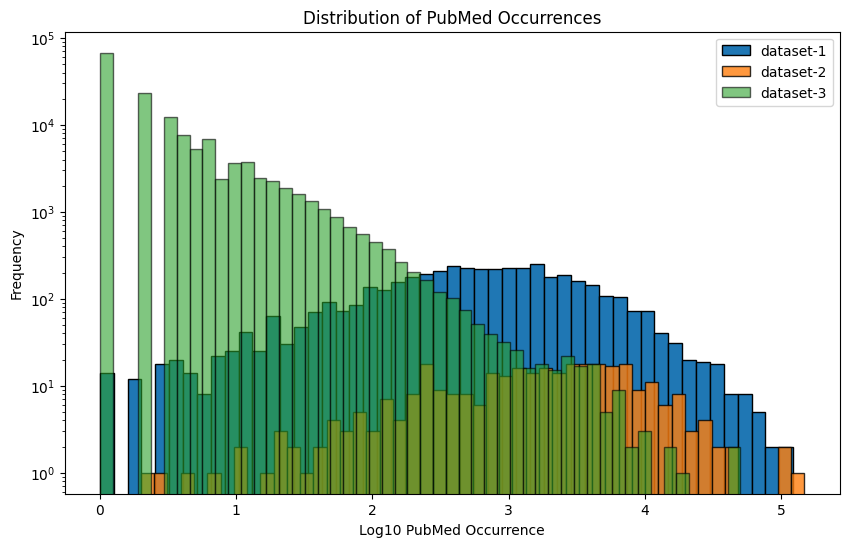

In [7]:
# @title Distribution of PubMed Occurrences

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_1['Log10 PubMed occurrence'], bins=50, edgecolor='black', label='dataset-1', alpha=1)
plt.hist(df_2['Log10 PubMed occurrence'], bins=50, edgecolor='black', label='dataset-2', alpha=0.8)
plt.hist(df_3['Log10 PubMed occurrence'], bins=50, edgecolor='black', label='dataset-3', alpha=0.6)
plt.xlabel('Log10 PubMed Occurrence')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of PubMed Occurrences');
plt.legend()

plt.show()

In [8]:
df_3['MeSH Symptom Term'].unique()[0:10]

array(['Aging, Premature', 'Asthenia', 'Fever', 'Fever of Unknown Origin',
       'Sweating Sickness', 'Hypothermia', 'Body Weight', 'Birth Weight',
       'Fetal Macrosomia', 'Body Weight Changes'], dtype=object)

In [9]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import pandas as pd

# Step 2: Load the data
# disease data
disease_data = pd.read_csv('data-set-1.txt', delimiter='\t')
# symptom data
symptom_data = pd.read_csv('data-set-2.txt', delimiter='\t')
# co-occurrence data
cooccurrence_data = pd.read_csv('data-set-3.txt', delimiter='\t')

In [10]:
error_counts = {}  # dictionary to store error counts

model = BayesianNetwork()

for index, row in cooccurrence_data.iterrows():
    disease = row['MeSH Disease Term']
    symptom = row['MeSH Symptom Term']
    try:
        model.add_edge(disease, symptom)
    except:
        if symptom in error_counts:
            error_counts[symptom] += 1
        else:
            error_counts[symptom] = 1

error_df = pd.DataFrame.from_dict(error_counts, orient='index', columns=['Error Count'])
error_df_sorted = error_df.sort_values(by='Error Count', ascending=False)

print(error_df_sorted)
print(f"error rate: {np.round(100*sum(error_df.values)[0]/len(cooccurrence_data), 2)}% (errors: {sum(error_df.values)[0]}, data: {len(cooccurrence_data)})")

                               Error Count
Vision Disorders                       113
Seizures                                98
Sleep Disorders                         94
Blindness                               89
Paresthesia                             85
...                                    ...
Necrolytic Migratory Erythema            1
Alien Hand Syndrome                      1
Decerebrate State                        1
Synkinesis                               1
Fetal Macrosomia                         1

[248 rows x 1 columns]
error rate: 4.06% (errors: 6007, data: 147978)


In [11]:
# count occurrences of unique values in 'MeSH Disease Term' and 'MeSH Symptom Term' columns
disease_counts = cooccurrence_data['MeSH Disease Term'].value_counts()
symptom_counts = cooccurrence_data['MeSH Symptom Term'].value_counts()

# take the union of the two sets, then reassign to the column in which they appear the most
values_to_drop = []
for value in set(disease_counts.index) | set(symptom_counts.index):
    disease_count = disease_counts.get(value, 0)
    symptom_count = symptom_counts.get(value, 0)
    if disease_count > symptom_count:
        values_to_drop.extend(cooccurrence_data[cooccurrence_data['MeSH Symptom Term'] == value].index)
    else: # symptom_count >= disease_count
        values_to_drop.extend(cooccurrence_data[cooccurrence_data['MeSH Disease Term'] == value].index)

# drop the identified rows from the DataFrame
cleaned_cooccurrence_data = cooccurrence_data.drop(values_to_drop)

print(f"Data clean size: {len(cooccurrence_data)} --> {len(cleaned_cooccurrence_data)}" )

Data clean size: 147978 --> 133464


In [12]:
model = BayesianNetwork()

error_counts = {}  # reset error counts

for index, row in cleaned_cooccurrence_data.iterrows():
    disease = row['MeSH Disease Term']
    symptom = row['MeSH Symptom Term']
    try:
        model.add_edge(disease, symptom)
    except:
        # oncrement the error count for the symptom
        if symptom in error_counts:
            error_counts[symptom] += 1
        else:
            error_counts[symptom] = 1

error_df = pd.DataFrame.from_dict(error_counts, orient='index', columns=['Error Count'])
error_df_sorted = error_df.sort_values(by='Error Count', ascending=False)

print(error_df_sorted)
print(f"error rate: {np.round(100*sum(error_df.values)/len(cleaned_cooccurrence_data), 2)}% (errors: {sum(error_df.values)}, data: {len(cleaned_cooccurrence_data)})")

Empty DataFrame
Columns: [Error Count]
Index: []
error rate: 0.0% (errors: 0, data: 133464)


In [13]:
disease_in_cooccurrence = all(item in cleaned_cooccurrence_data['MeSH Disease Term'].unique() for item in disease_data['MeSH Disease Term'].unique())
print("All disease terms in disease_data appear in cooccurrence_data:", disease_in_cooccurrence)

cooccurrence_in_disease = all(item in disease_data['MeSH Disease Term'].unique() for item in cleaned_cooccurrence_data['MeSH Disease Term'].unique())
print("All disease terms in cooccurrence_data appear in disease_data:", cooccurrence_in_disease)

symptom_in_cooccurrence = all(item in cleaned_cooccurrence_data['MeSH Symptom Term'].unique() for item in symptom_data['MeSH Symptom Term'].unique())
print("All symptom terms in symptom_data appear in cooccurrence_data:", symptom_in_cooccurrence)

cooccurrence_in_disease = all(item in symptom_data['MeSH Symptom Term'].unique() for item in cleaned_cooccurrence_data['MeSH Symptom Term'].unique())
print("All symptom terms in cooccurrence_data appear in symptom_data:", cooccurrence_in_disease)

###                    It is critical that                          ###
# All disease terms in cooccurrence_data appear in disease_data: True #
# All symptom terms in cooccurrence_data appear in symptom_data: True #

All disease terms in disease_data appear in cooccurrence_data: False
All disease terms in cooccurrence_data appear in disease_data: True
All symptom terms in symptom_data appear in cooccurrence_data: False
All symptom terms in cooccurrence_data appear in symptom_data: True


# Great, now lets move on to defining the probabilties

## Prios (Niave Guess)

In [14]:
priors = {}
disease_occurrences = {}
missing_disease_occurrences = {}

for index, row in disease_data.iterrows():
    disease_name = row['MeSH Disease Term']
    if disease_name in cleaned_cooccurrence_data['MeSH Disease Term'].unique():
        priors[disease_name] = row['PubMed occurrence']
        disease_occurrences[disease_name] = row['PubMed occurrence']
    else:
        # print(f"Missing Disease: {disease_name}")
        missing_disease_occurrences[disease_name] = row['PubMed occurrence']

# total occurrences of the specified diseases (including missing ones)
total_occurrences = sum(priors.values()) + sum(missing_disease_occurrences.values())

# normalize
for disease in priors:
    priors[disease] = priors[disease] / total_occurrences

print("\n\n\n Priors:", priors)
print("Disease Occurrences:", disease_occurrences)
print("Missing Disease Occurrences:", missing_disease_occurrences)




 Priors: {'Breast Neoplasms': 0.011926863868880025, 'Hypertension': 0.010469793104148162, 'Coronary Artery Disease': 0.008081512433989288, 'Lung Neoplasms': 0.007612150635277779, 'Myocardial Infarction': 0.0074107446576186205, 'HIV Infections': 0.006498953254882582, 'Coronary Disease': 0.006278226354947981, 'Asthma': 0.00621284747654118, 'Adenocarcinoma': 0.005938256187232618, 'Dementia': 0.005443230739236051, 'Prostatic Neoplasms': 0.005328476170569786, 'Skin Neoplasms': 0.005229334468388727, 'Carcinoma, Squamous Cell': 0.0049025376567702564, 'Liver Neoplasms': 0.004781928263172038, 'Arthritis, Rheumatoid': 0.004767193620426625, 'Schizophrenia': 0.004541099797637734, 'Diabetes Mellitus, Type 2': 0.0045123135750556355, 'Brain Neoplasms': 0.004468402388065993, 'Heart Failure': 0.004323788212246772, 'Postoperative Complications': 0.00404461064340818, 'Kidney Failure, Chronic': 0.004006651861766022, 'Alzheimer Disease': 0.003870819923344729, 'Diabetes Mellitus': 0.0037510887534863042, 

In [15]:
print(f"total count of disease for prios lost: {sum(missing_disease_occurrences.values())}, ({round(100*sum(missing_disease_occurrences.values())/sum(disease_occurrences.values()), 2)})% after cleaning")

total count of disease for prios lost: 669216, (6.99)% after cleaning


#Subset Test

In [138]:
# Add suffix to symptoms
# disease data
disease_data = pd.read_csv('data-set-1.txt', delimiter='\t')
# symptom data
symptom_data = pd.read_csv('data-set-2.txt', delimiter='\t')
# co-occurrence data
cooccurrence_data = pd.read_csv('data-set-3.txt', delimiter='\t')

symptom_data['MeSH Symptom Term'] = symptom_data['MeSH Symptom Term'] + ' (symptom)'

disease_data['MeSH Disease Term'] = disease_data['MeSH Disease Term'] + ' (disease)'

cooccurrence_data['MeSH Symptom Term'] = cooccurrence_data['MeSH Symptom Term'] + ' (symptom)'
cooccurrence_data['MeSH Disease Term'] = cooccurrence_data['MeSH Disease Term'] + ' (disease)'

print("Sampled Symptoms after suffix addition:")
print(symptom_data.head())
print("Sampled Diseases after suffix addition:")
print(disease_data.head())
print("Filtered Co-occurrence Data after suffix addition:")
print(cooccurrence_data.head())

symptom_sample_size = 12
disease_sample_size = 300

sampled_symptom_data = symptom_data.nlargest(symptom_sample_size, 'PubMed occurrence')
# sampled_symptom_data = symptom_data # this cancels subset

sampled_disease_data = disease_data.nlargest(disease_sample_size, 'PubMed occurrence')
# sampled_disease_data = disease_data # this cancels subset

sampled_symptom_data = sampled_symptom_data[~sampled_symptom_data['MeSH Symptom Term'].isin(sampled_disease_data['MeSH Disease Term'])]
sampled_disease_data = sampled_disease_data[~sampled_disease_data['MeSH Disease Term'].isin(sampled_symptom_data['MeSH Symptom Term'])]

filtered_cooccurrence_data = cooccurrence_data[
    (cooccurrence_data['MeSH Symptom Term'].isin(sampled_symptom_data['MeSH Symptom Term'])) &
    (cooccurrence_data['MeSH Disease Term'].isin(sampled_disease_data['MeSH Disease Term']))
]

# mu = sampled_disease_data['PubMed occurrence'].mean()
# sigma = sampled_disease_data['PubMed occurrence'].std()

# from numpy.random import normal
# filtered_cooccurrence_data['PubMed occurrence'] = normal(mu, sigma, filtered_cooccurrence_data.shape[0])


print("Sampled Diseases:")
print(sampled_disease_data.head())
print("Sampled Symptoms:")
print(sampled_symptom_data.head())
print("Filtered Co-occurrence Data:")
print(filtered_cooccurrence_data.head())

Sampled Symptoms after suffix addition:
              MeSH Symptom Term  PubMed occurrence
0         Body Weight (symptom)             147857
1                Pain (symptom)             103168
2             Obesity (symptom)             100301
3              Anoxia (symptom)              47351
4  Mental Retardation (symptom)              43883
Sampled Diseases after suffix addition:
                   MeSH Disease Term  PubMed occurrence
0         Breast Neoplasms (disease)             122226
1             Hypertension (disease)             107294
2  Coronary Artery Disease (disease)              82819
3           Lung Neoplasms (disease)              78009
4    Myocardial Infarction (disease)              75945
Filtered Co-occurrence Data after suffix addition:
            MeSH Symptom Term  \
0  Aging, Premature (symptom)   
1  Aging, Premature (symptom)   
2  Aging, Premature (symptom)   
3  Aging, Premature (symptom)   
4  Aging, Premature (symptom)   

                            

In [102]:
# Assuming sampled_disease_data, sampled_symptom_data, and filtered_cooccurrence_data are Pandas DataFrames

sampled_disease_data.to_csv('sampled_disease_data.csv', index=False)

sampled_symptom_data.to_csv('sampled_symptom_data.csv', index=False)

filtered_cooccurrence_data.to_csv('filtered_cooccurrence_data.csv', index=False)

In [146]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def make_bay_net(disease_data, symptom_data, cooccurrence_data, top_k=5):
    model = BayesianNetwork()

    diseases = disease_data['MeSH Disease Term'].tolist()
    symptoms = symptom_data['MeSH Symptom Term'].tolist()

    # nodes
    model.add_nodes_from(diseases + symptoms)

    # edges based on co-occurrence data
    for index, row in tqdm(cooccurrence_data.iterrows(), total=cooccurrence_data.shape[0], desc="Adding edges"):
        symptom = row['MeSH Symptom Term']
        disease = row['MeSH Disease Term']
        model.add_edge(symptom, disease)

    cpds = []

    all_symptom_occurrences = sum(symptom_data['PubMed occurrence'])
    all_disease_occurrences = sum(disease_data['PubMed occurrence'])

    # dict for lookup
    symptom_occurrence_dict = dict(zip(symptom_data['MeSH Symptom Term'], symptom_data['PubMed occurrence']))
    disease_occurrence_dict = dict(zip(disease_data['MeSH Disease Term'], disease_data['PubMed occurrence']))
    cooccurrence_dict = {(row['MeSH Symptom Term'], row['MeSH Disease Term']): row['PubMed occurrence']
                         for _, row in cooccurrence_data.iterrows()}
    tfidf_dict = {(row['MeSH Symptom Term'], row['MeSH Disease Term']): row['TFIDF score']
                  for _, row in cooccurrence_data.iterrows()}

    # norm TFIDF scores
    max_tfidf = max(tfidf_dict.values())
    min_tfidf = min(tfidf_dict.values())
    normalized_tfidf_dict = {k: (v - min_tfidf) / (max_tfidf - min_tfidf) for k, v in tfidf_dict.items()}

    # compute prior probabilities for diseases
    disease_prior_dict = {disease: count / all_disease_occurrences for disease, count in disease_occurrence_dict.items()}

    # CPDs for symptoms
    for symptom in tqdm(symptoms, desc="Defining CPDs for symptoms"):
        symptom_occurrence = symptom_occurrence_dict[symptom]
        naive_symptom_yes = symptom_occurrence / all_symptom_occurrences
        naive_symptom_no = 1 - naive_symptom_yes
        cpd_symptom = TabularCPD(variable=symptom, variable_card=2, values=[[naive_symptom_no], [naive_symptom_yes]])
        cpds.append(cpd_symptom)

    def define_cpd_for_disease(disease):
        evidence = list(model.get_parents(disease))
        evidence_card = [2] * len(evidence)

        if len(evidence) == 0:
            disease_prior = disease_prior_dict[disease]
            naive_disease_yes = disease_prior
            naive_disease_no = 1 - naive_disease_yes
            cpd_disease = TabularCPD(variable=disease, variable_card=2, values=[[naive_disease_no], [naive_disease_yes]])
        else:
            values = []
            for i in range(2 ** len(evidence)):
                binary_state = [(i >> bit) & 1 for bit in range(len(evidence))]
                prob = 1.0
                for j, symptom in enumerate(evidence):
                    tfidf_score = normalized_tfidf_dict.get((symptom, disease), 0.5)  # Use 0 if not found
                    if binary_state[j] == 1:
                        prob *= tfidf_score
                    else:
                        prob *= 1 - tfidf_score
                values.append(prob)

            # normalize the probabilities and incorporate the disease prior
            total = sum(values) + len(values)  # adding len(values) for smoothing
            normalized_values = [(val + 1) / total for val in values]  # adding 1 for smoothing
            normalized_values = [v * disease_prior_dict[disease] for v in normalized_values]  # Adjust by prior
            cpd_disease = TabularCPD(variable=disease, variable_card=2, values=[normalized_values, [1 - val for val in normalized_values]], evidence=evidence, evidence_card=evidence_card)
        return cpd_disease

    # multithreading
    with ThreadPoolExecutor() as executor:
        cpd_diseases = list(tqdm(executor.map(define_cpd_for_disease, diseases), total=len(diseases), desc="Defining CPDs for diseases"))

    cpds.extend(cpd_diseases)
    model.add_cpds(*cpds)

    # validation
    assert model.check_model()
    return model

def infer_from_bay(infer, symptoms, sampled_disease_data):
    diseases = sampled_disease_data['MeSH Disease Term'].tolist()
    evidence = {symptom: 1 for symptom in symptoms}

    results = []
    for disease in diseases:
        result = infer.query(variables=[disease], evidence=evidence, show_progress=False)
        disease_prob_true = result.values[1]
        results.append((disease, disease_prob_true))

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    return sorted_results[:10]


model = make_bay_net(sampled_disease_data, sampled_symptom_data, filtered_cooccurrence_data)
infer = VariableElimination(model)

symptoms = ['Pain (symptom)']
top_10_probabilities = infer_from_bay(infer, symptoms, sampled_disease_data)
print()
print(top_10_probabilities)


Defining CPDs for diseases: 100%|██████████| 5/5 [00:00<00:00, 27521.68it/s]


[('Myocardial Infarction (disease)', 0.89735554705134), ('Coronary Artery Disease (disease)', 0.8959162886151103), ('Lung Neoplasms (disease)', 0.8944357934449912), ('Hypertension (disease)', 0.8909738921874609), ('Breast Neoplasms (disease)', 0.8834344696776023)]


In [147]:
### NOT SURE WHY IT DOESNT WORK, IT WORKS ON THIS SMALL SUBSAMPLE ###

sampled_disease_data = pd.DataFrame({
    'MeSH Disease Term': [
        'Breast Neoplasms (disease)', 'Hypertension (disease)', 'Coronary Artery Disease (disease)',
        'Lung Neoplasms (disease)', 'Myocardial Infarction (disease)'
    ],
    'PubMed occurrence': [122226, 107294, 82819, 78009, 75945]
})

sampled_symptom_data = pd.DataFrame({
    'MeSH Symptom Term': [
        'Body Weight (symptom)', 'Pain (symptom)', 'Obesity (symptom)', 'Anoxia (symptom)', 'Mental Retardation (symptom)'
    ],
    'PubMed occurrence': [147857, 103168, 100301, 47351, 43883]
})

filtered_cooccurrence_data = pd.DataFrame({
    'MeSH Symptom Term': [
        'Body Weight (symptom)', 'Pain (symptom)', 'Obesity (symptom)', 'Anoxia (symptom)', 'Mental Retardation (symptom)'
    ],
    'MeSH Disease Term': [
        'Breast Neoplasms (disease)', 'Hypertension (disease)', 'Coronary Artery Disease (disease)',
        'Lung Neoplasms (disease)', 'Myocardial Infarction (disease)'
    ],
    'PubMed occurrence': [402, 172, 16, 4, 10],
    'TFIDF score': [402.928399, 172.683599, 16.092378, 4.951501, 10.0]
})

In [155]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

# perform inference and get top 10 probabilities
def infer_from_bay(infer, symptoms, sampled_disease_data):
    diseases = sampled_disease_data['MeSH Disease Term'].tolist()
    evidence = {symptom: 1 for symptom in symptoms}

    results = []
    for disease in diseases:
        result = infer.query(variables=[disease], evidence=evidence, show_progress=False)

        disease_prob_true = result.values[1]
        results.append((disease, disease_prob_true))

    total_prob = sum(prob for _, prob in results)
    normalized_results = [(disease, prob / total_prob) for disease, prob in results]

    sorted_results = sorted(normalized_results, key=lambda x: x[1], reverse=True)

    return sorted_results[:10]

model = make_bay_net(sampled_disease_data, sampled_symptom_data, filtered_cooccurrence_data)
infer = VariableElimination(model)

top_10_probabilities = infer_from_bay(infer, ['Pain (symptom)'], sampled_disease_data)
print()
print(top_10_probabilities)

Defining CPDs for diseases: 100%|██████████| 5/5 [00:00<00:00, 29746.84it/s]


[('Myocardial Infarction (disease)', 0.2011053833799958), ('Coronary Artery Disease (disease)', 0.20078283272484918), ('Lung Neoplasms (disease)', 0.20045104054976612), ('Hypertension (disease)', 0.19967519759442134), ('Breast Neoplasms (disease)', 0.19798554575096744)]


#Justification:

## Relevance of Symptoms to Diseases:

TFIDF scores provide a measure of the relevance of an item relative to the rest of the corpus. This way we can measure the imporance of symptoms to diseases based on their co-occurrence in PubMed.

Higher TFIDF scores indicate a stronger association between a symptom and a disease.

Although TFIDF is not a direct probability measure, I believe it can serve as a proxy to estimate the likelihood of a disease given the presence of symptoms.

#Inference UI

In [156]:
import ipywidgets as widgets
from IPython.display import display

### implement search based off filter contianing word ###

def filter_strings(string_list, input_string):
  filtered_list = [s for s in string_list if input_string.lower() in s.lower()]
  return filtered_list

filtered_strings = []

# filter strings on change
def on_input_change(change, arr):
  with output_widget:
    output_widget.clear_output()
    filtered_strings = filter_strings(arr, change.new)
    print(filtered_strings)
    print("User choices:", users_symptoms)

def on_submit(sender):
  with output_widget:
    output_widget.clear_output()
    filtered_strings = filter_strings(sampled_symptom_data['MeSH Symptom Term'].unique(), input_widget.value)
    if filtered_strings:
      users_symptoms.append(filtered_strings[0])
      print("Added symptom:", filtered_strings[0])
    else:
      print("No matching symptoms found.")
    print("User choices:", users_symptoms)

users_symptoms = []

submit_button = widgets.Button(description="Submit")
input_widget = widgets.Text(description="Enter string:")
output_widget = widgets.Output()

submit_button.on_click(on_submit)
input_widget.observe(lambda change: on_input_change(change, sampled_symptom_data['MeSH Symptom Term'].unique()), names='value')

display(widgets.HBox([input_widget, submit_button]), output_widget)

Output()

In [157]:
top_10_probabilities = infer_from_bay(infer, users_symptoms, sampled_disease_data)
print()
print(top_10_probabilities)


[('Lung Neoplasms (disease)', 0.209275810588452), ('Myocardial Infarction (disease)', 0.1988857459945748), ('Coronary Artery Disease (disease)', 0.19856675539078444), ('Hypertension (disease)', 0.19747134543455921), ('Breast Neoplasms (disease)', 0.1958003425916295)]
